In [1]:
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()

2024-11-18 11:21:16.859809: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 11:21:16.897712: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 11:21:16.897744: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 11:21:16.897772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 11:21:16.904908: I tensorflow/core/platform/cpu_feature_g

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from tensorflow.keras.layers import Bidirectional, concatenate, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.callbacks import CSVLogger
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from tensorflow.python.keras.layers import Layer, InputSpec
import tensorflow as tf
tf.compat.v1.reset_default_graph()
from sklearn.metrics import accuracy_score

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten, Reshape, multiply
from keras.layers import concatenate, GRU, Input, LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D,  GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model
from keras.preprocessing import text, sequence
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.models import Model

In [3]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        #x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [4]:
drop_rate = 0.2
stochastic_depth_rate = 0.1

w1 = 100

positional_emb = False
conv_layers = 2
num_classes = 1
input_shape = (600,1)
image_size = 600  # We'll resize input images to this size
projection_dim = int(2*w1)
num_heads = 4
transformer_units = [
    projection_dim,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4

In [5]:
import tensorflow as tf
class CCTTokenizer1(layers.Layer):
    def __init__(
        self,
        kernel_size=4,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=(2,2,2,2,2,2,2,2),
        num_conv_layers=conv_layers,
        num_output_channels=[int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim)],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer1, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = tf.keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv1D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="same",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            #self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool1D(pooling_kernel_size, (pooling_stride[i]), "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, 1))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = dummy_outputs.shape[1]
            projection_dim = dummy_outputs.shape[-1]

            print(dummy_outputs,sequence_length,projection_dim)
            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [6]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [7]:
#def create_vit_classifier(inputs):
def create_cct_model1(inputs):


    # Augment data.
    #augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer1()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)

        #print(encoded_patches)
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        #x3 = x2
        
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)

        # Skip connection 2.
        #print(x3)
        x3 = StochasticDepth(dpr[i])(x3)
        #print(x3)
        encoded_patches = layers.Add()([x3, x2])
     
    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    
    ''' 
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)
    '''
    return representation

In [8]:
inputs = layers.Input(shape=input_shape,name='input')

featuresP = create_cct_model1(inputs)
#featuresP = layers.Dropout(0.2)(featuresP)
featuresP = layers.Flatten()(featuresP)
logitp = layers.Dense(1, activation='sigmoid')(featuresP)


#logitp  = Conv2D(1,  3, strides =(1), padding='same',activation='sigmoid', kernel_initializer='he_normal',name='picker_P')(featuresP)


model = Model(inputs=[inputs], outputs=[logitp])
model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 600, 1)]             0         []                            
                                                                                                  
 cct_tokenizer1 (CCTTokeniz  (None, 150, 200)             160800    ['input[0][0]']               
 er1)                                                                                             
                                                                                                  
 layer_normalization (Layer  (None, 150, 200)           

In [9]:
inputs = layers.Input(shape=input_shape,name='input')

featuresP = create_cct_model1(inputs)
featuresP = layers.Flatten()(featuresP)
featuresP = layers.Dropout(0.2)(featuresP)
logitp = layers.Dense(1, activation='sigmoid')(featuresP)


#logitp  = Conv2D(1,  3, strides =(1), padding='same',activation='sigmoid', kernel_initializer='he_normal',name='picker_P')(featuresP)


model = Model(inputs=[inputs], outputs=[logitp])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 600, 1)]             0         []                            
                                                                                                  
 cct_tokenizer1_1 (CCTToken  (None, 150, 200)             160800    ['input[0][0]']               
 izer1)                                                                                           
                                                                                                  
 layer_normalization_9 (Lay  (None, 150, 200)             400       ['cct_tokenizer1_1[0][0]']    
 erNormalization)                                                                                 
                                                                                            

In [13]:
model.load_weights('../../../model/Toc2me_20240819_Transfer_Learning_21916data/best_weigths_Binary_Toc2me_Transfer_SCSN_20241013_21916data_90.h5')

In [14]:
from obspy.core.event import read_events
import os
import obspy
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

datadir = '../all_data_demo'
evtdirs = []
with open(os.path.join(datadir, 'catalog_sorted_ToC2ME.txt'), 'r') as f:
    lines = f.readlines()
for line in lines:
    evtdirs.append(os.path.join(datadir, line.strip()))

for i, evtdir in enumerate(evtdirs):
    print('{0:s} {1:d}/{2:d}'.format(evtdir, i+1, len(evtdirs)))
    polall = []
    datall = []        
    evlas = []
    evlos = []
    evdps = []
    stlas = []
    stlos = []
    stalist = []
    
    # read waveforms
    sacfiles = np.sort(glob.glob(os.path.join(evtdir, '*DHZ.SAC')))
    for j, sacfile in enumerate(sacfiles):
        try:
            st = obspy.read(sacfile)
        except TypeError:
            print(f'Skipped wrong file: {sacfile}')
            continue
        
        t = st[0].stats.starttime + 5
        st.trim(t - 0.6 + 0.002, t + 0.6)
        dat = st[0].data

        if len(dat) == 600:
            dat = dat / np.max(np.abs(dat))
            dat = np.reshape(dat, (dat.shape[0], 1))
            datall.append(dat)
            
            stalist.append(st[0].stats.sac.kstnm)
            stlas.append(st[0].stats.sac.stla)
            stlos.append(st[0].stats.sac.stlo)            
            evlas.append(st[0].stats.sac.evla)
            evlos.append(st[0].stats.sac.evlo)
            evdps.append(st[0].stats.sac.evdp)
            
    if len(datall) == 0:
        print(f"No valid data for directory: {evtdir}")
        continue

    datall = np.array(datall)

    try:
        if datall.ndim != 3 or datall.shape[1] != 600 or datall.shape[2] != 1:
            raise ValueError(f"Invalid input shape: {datall.shape}")
        out = model.predict(datall, batch_size=1024, verbose=1)
        pols = [pol[0] for pol in out]
    except ValueError as e:
        print(f"Skipped wrong input shape: {e}")
        continue

    # save model prediction
    outdir = './result_ToC2ME_eqpolarity'
    filename = evtdir.split('/')[-1] + '.polarity'
    with open(os.path.join(outdir, filename), 'w') as f:
        for sta, evla, evlo, evdp, stla, stlo, pol in zip(stalist, evlas, evlos, evdps, stlas, stlos, pols):
            f.write('{0:s} {1:f} {2:f} {3:f} {4:f} {5:f} {6:f}\n'.format(sta, evla, evlo, evdp, stla, stlo, pol))


../all_data_demo/20161104064824.680 1/3


/tmp/ipykernel_869357/3635558723.py:41: RuntimeWarning: invalid value encountered in divide
  dat = dat / np.max(np.abs(dat))
/home/jiachenhu/miniconda3/envs/eqp/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-11-18 11:24:42.879754: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_17/Sigmoid' id:2513 op device:{requested: '', assigned: ''} def:{{{node dense_17/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_17/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


../all_data_demo/20161125051408.940 2/3
../all_data_demo/20161128051644.670 3/3


/var/folders/r2/654xhrgs4dx3tgsvvyd1q5lw0000gn/T/ipykernel_1366/3079098267.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('{0:s} Prob={1:f}'.format(stalist[idx],float(out[idx])))
/var/folders/r2/654xhrgs4dx3tgsvvyd1q5lw0000gn/T/ipykernel_1366/3079098267.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


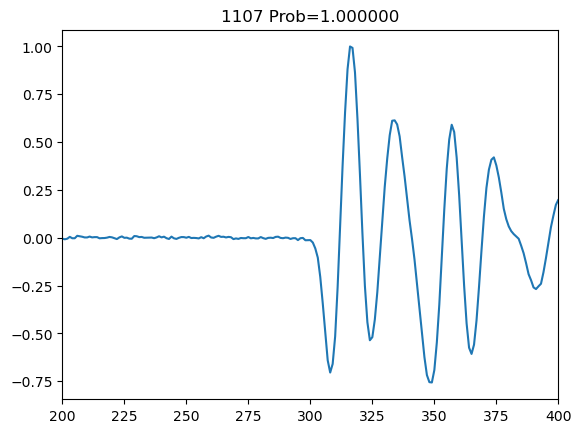

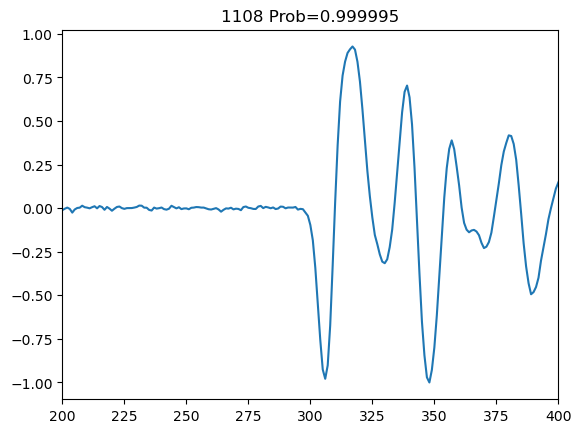

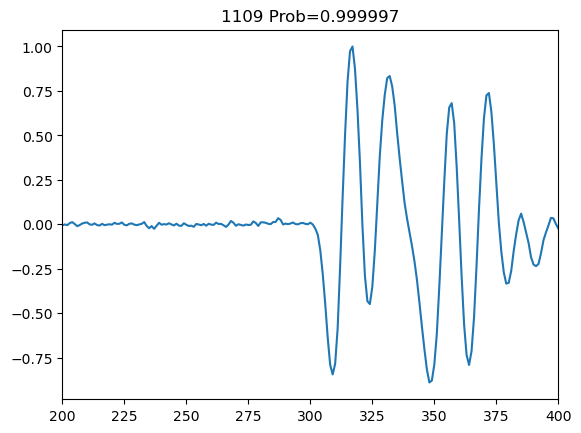

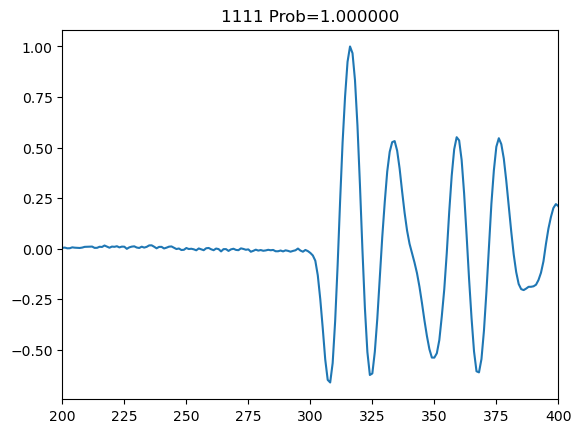

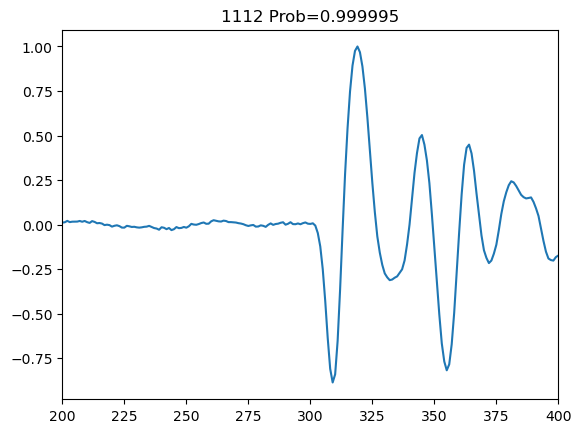

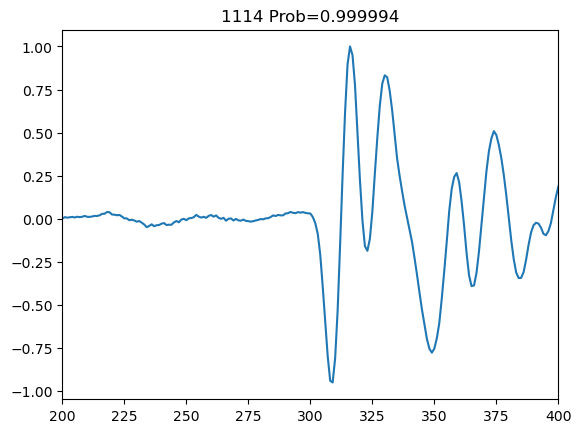

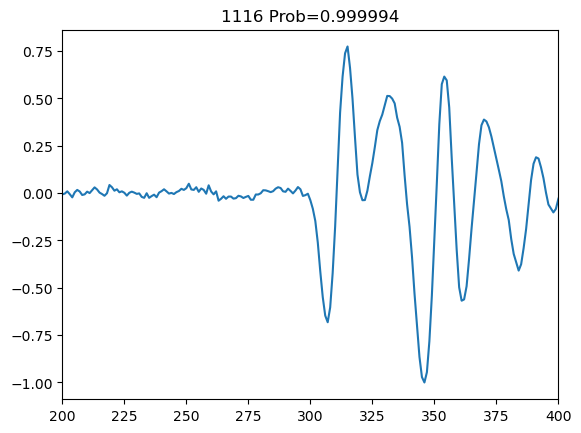

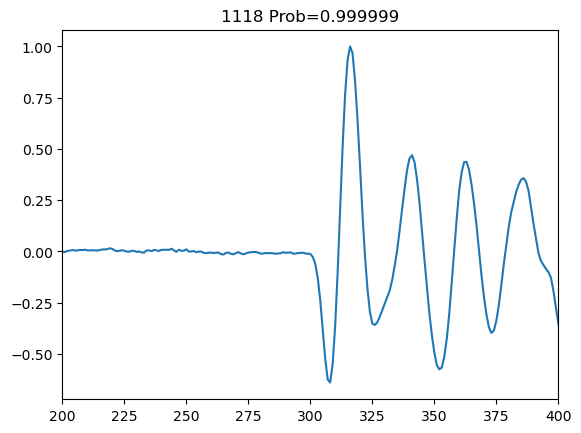

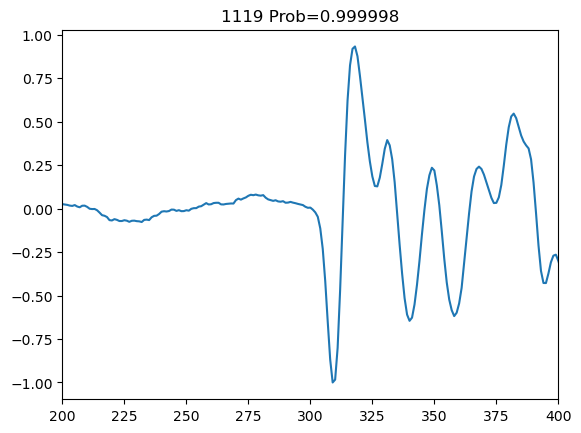

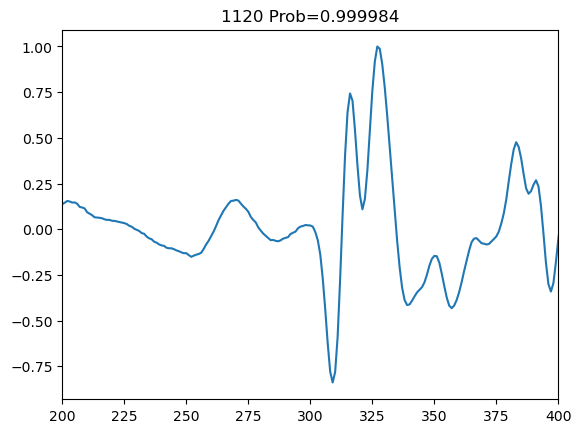

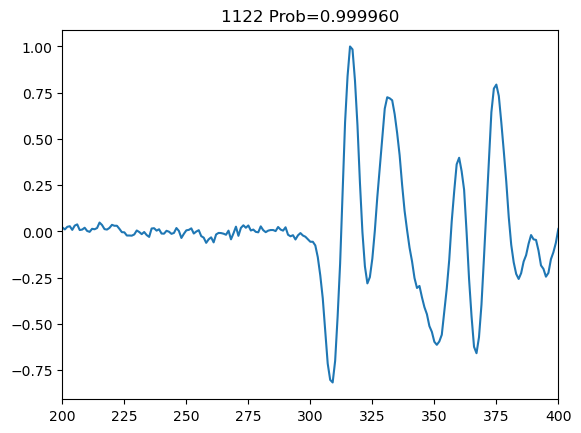

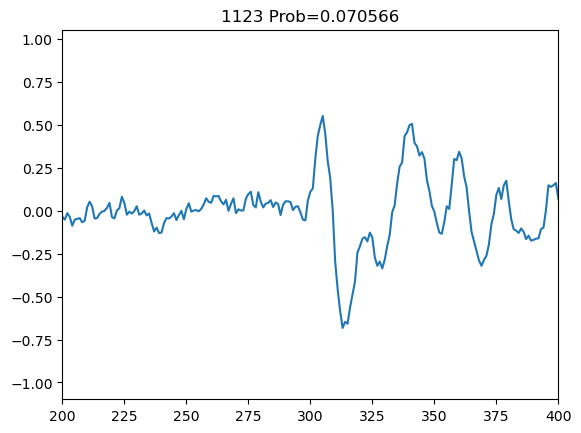

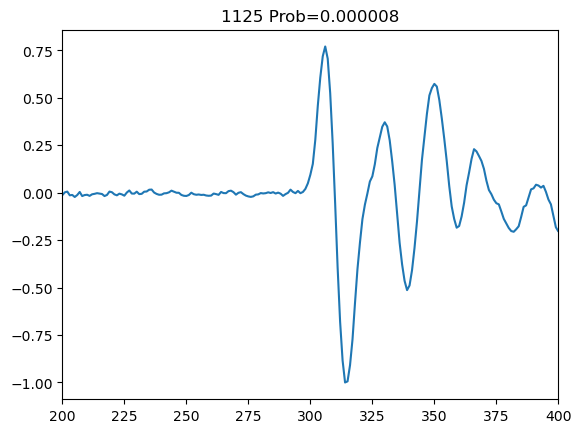

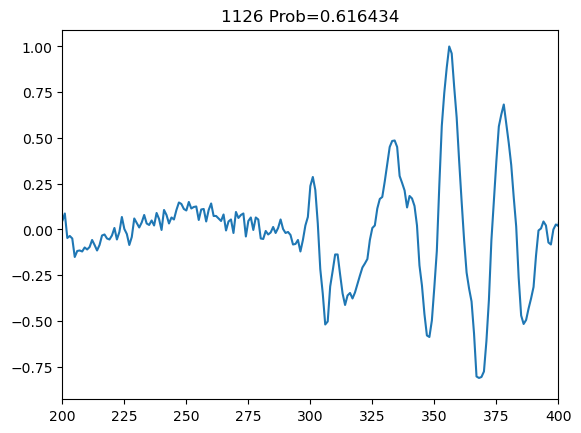

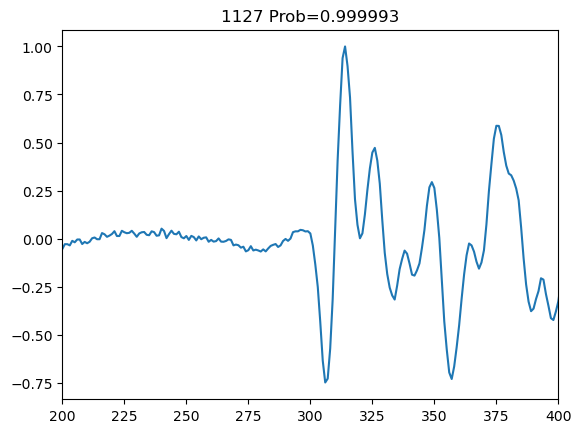

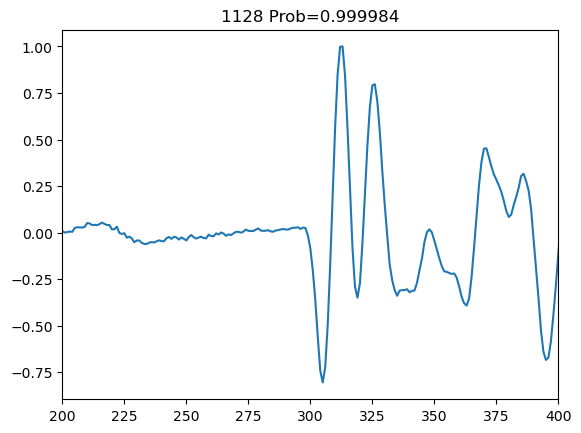

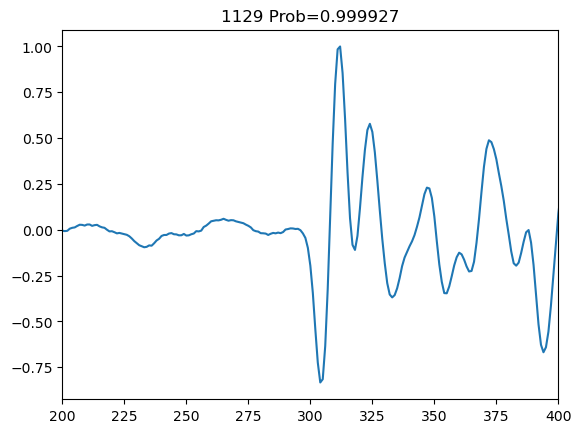

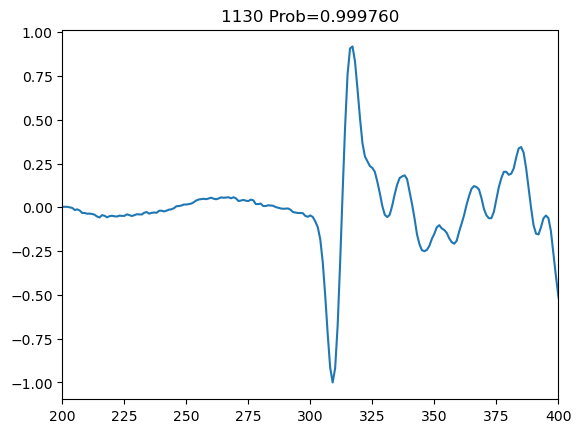

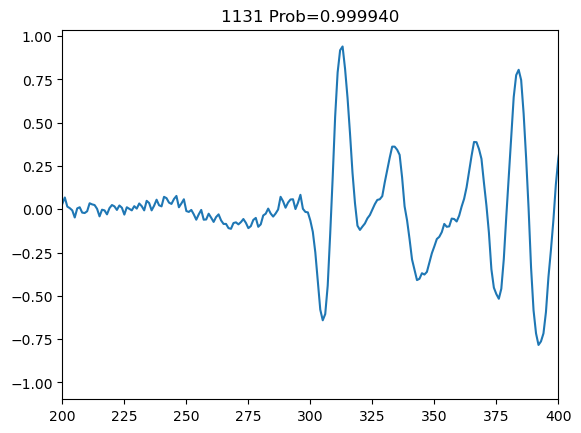

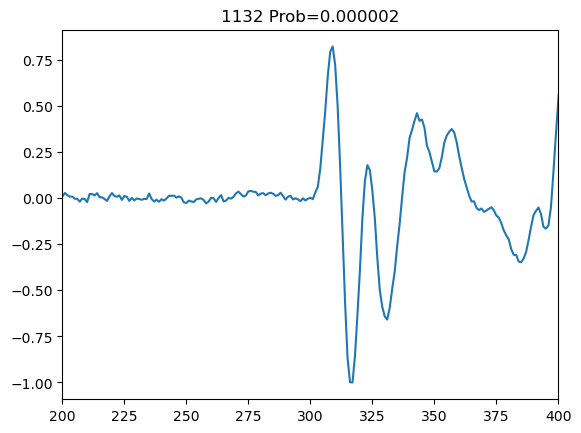

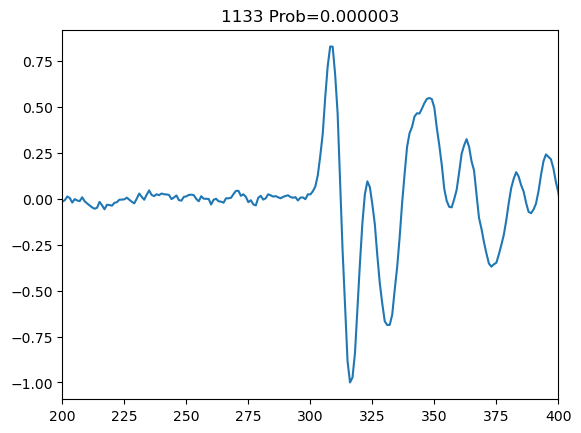

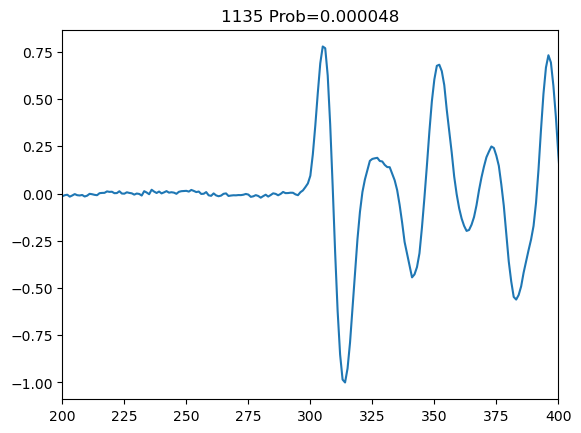

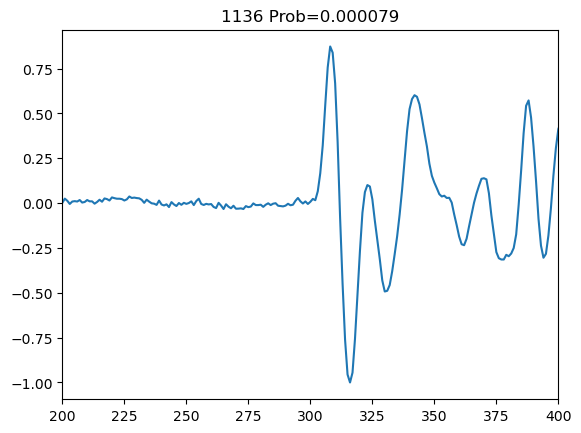

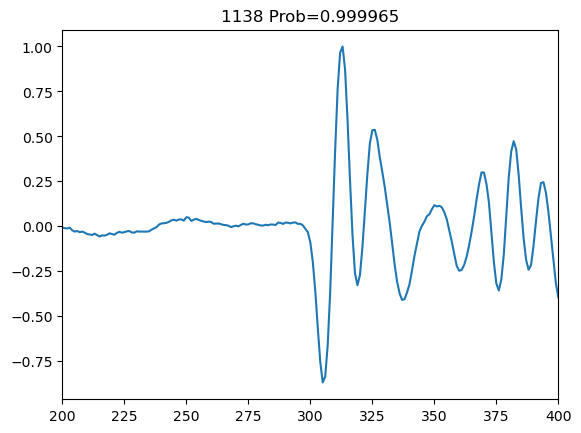

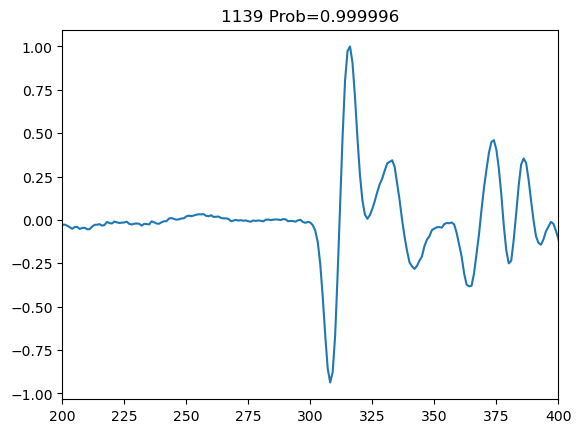

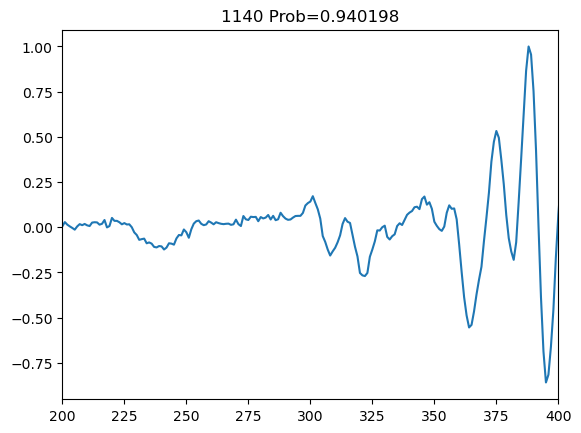

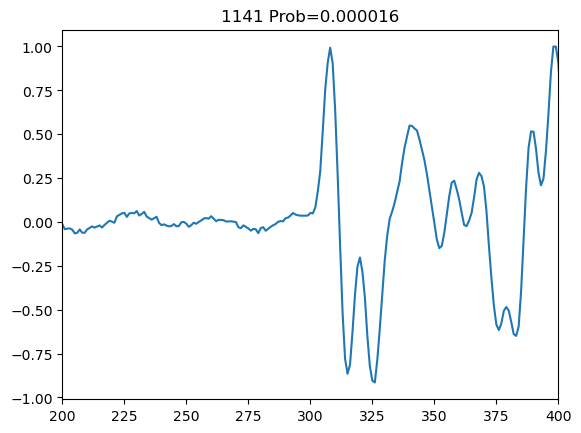

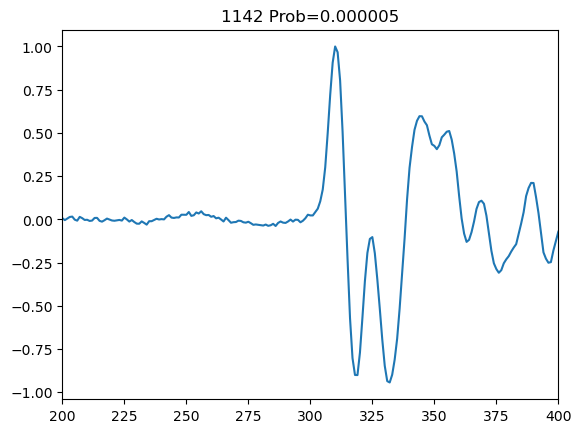

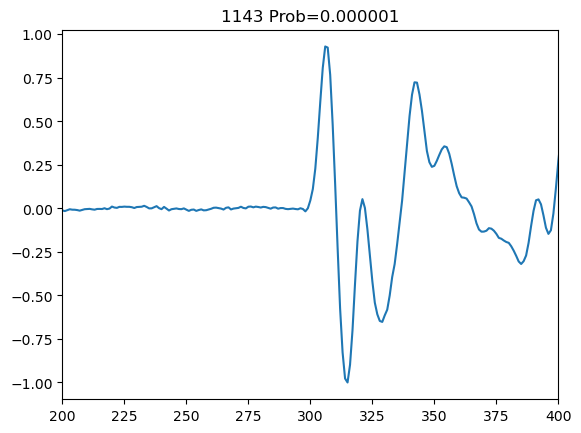

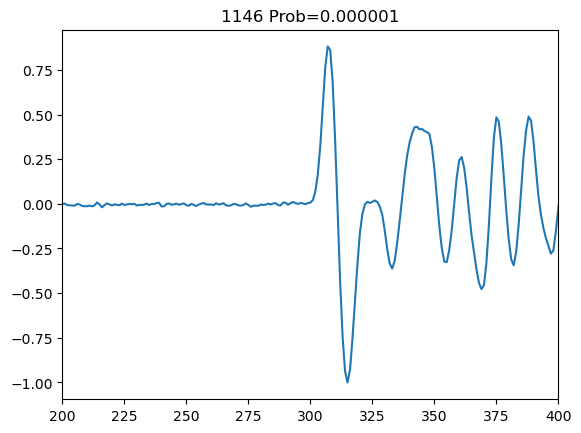

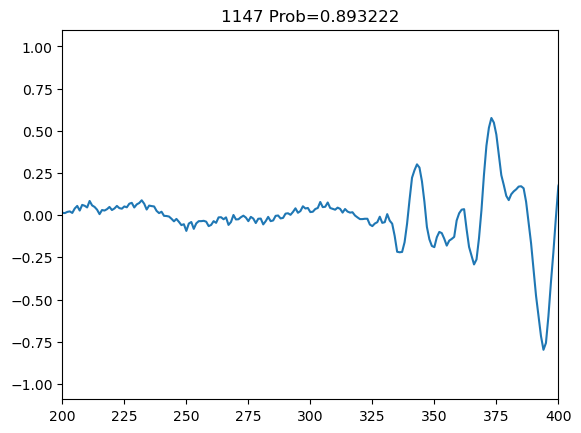

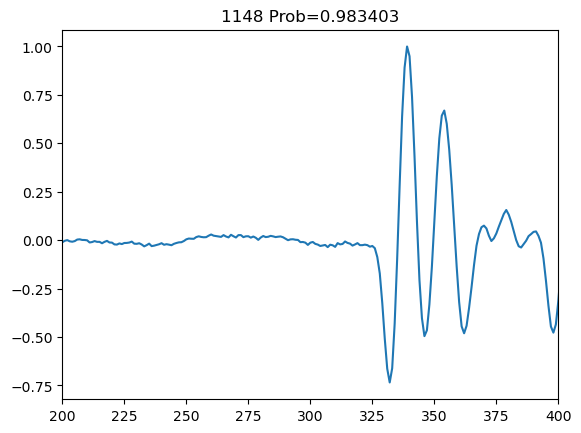

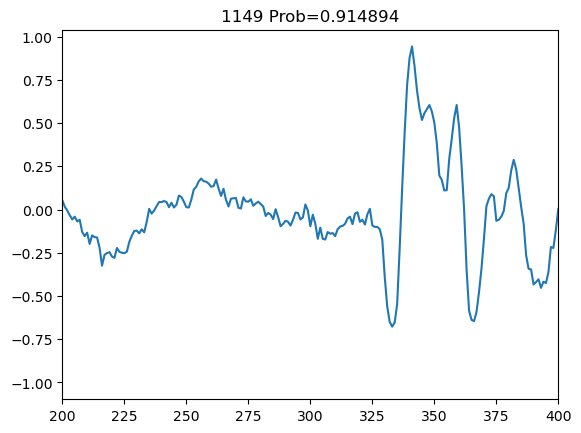

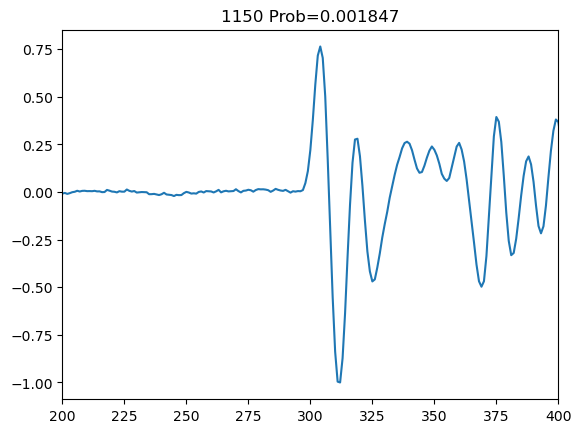

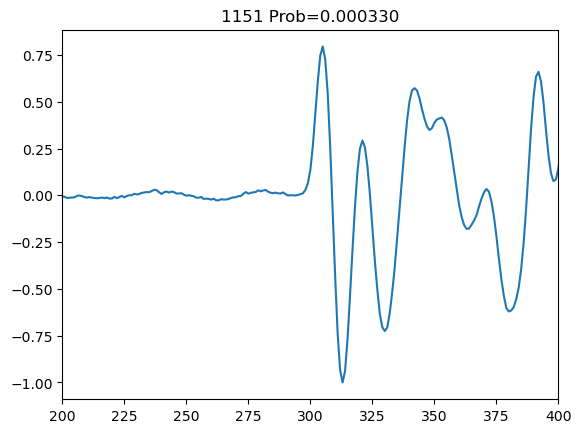

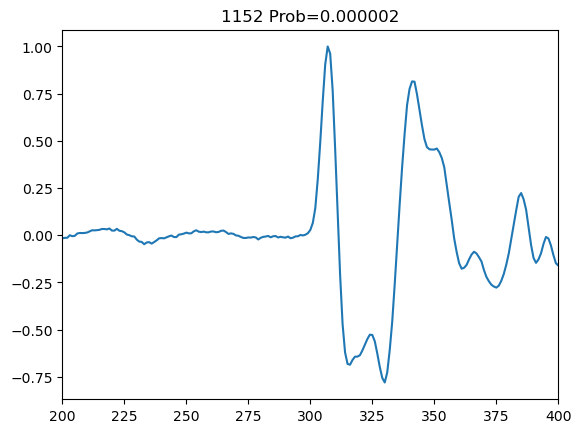

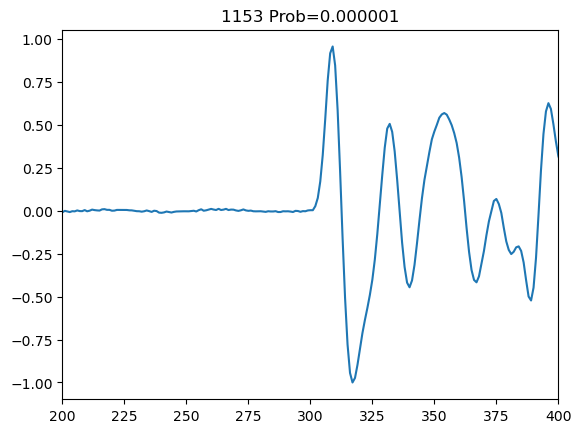

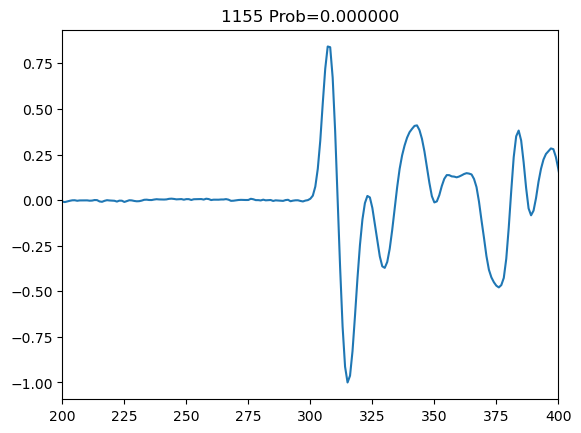

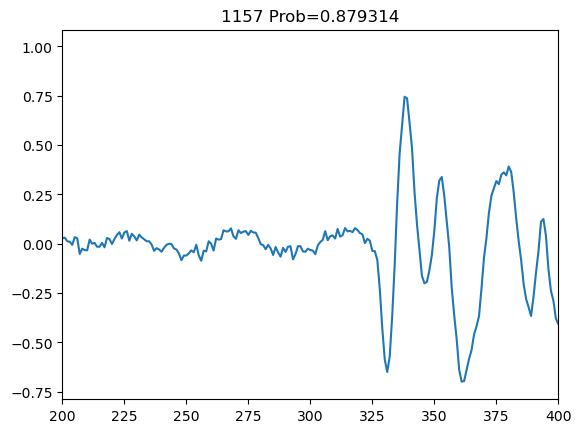

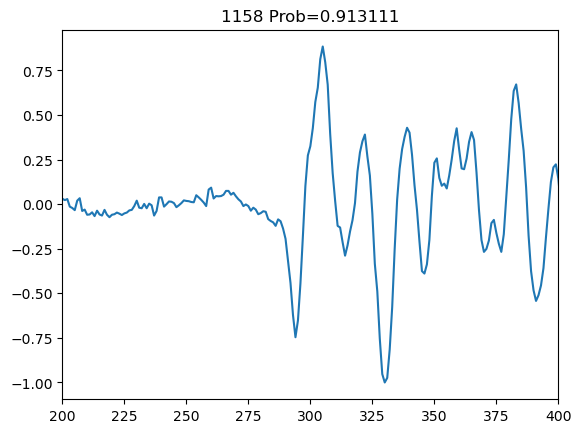

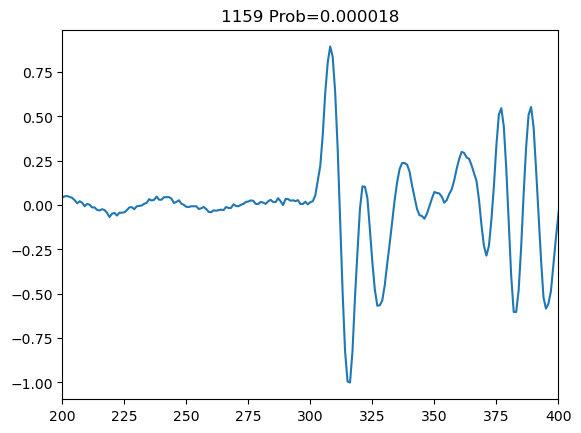

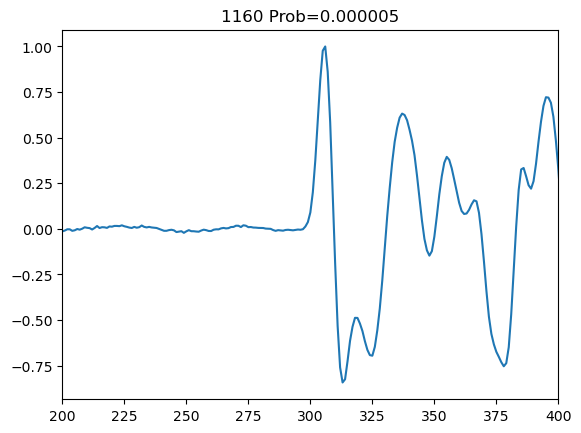

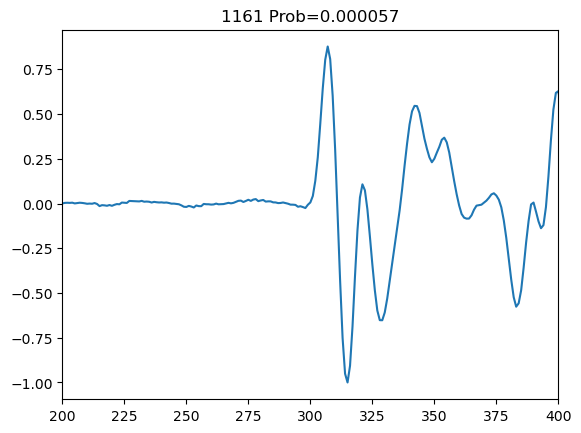

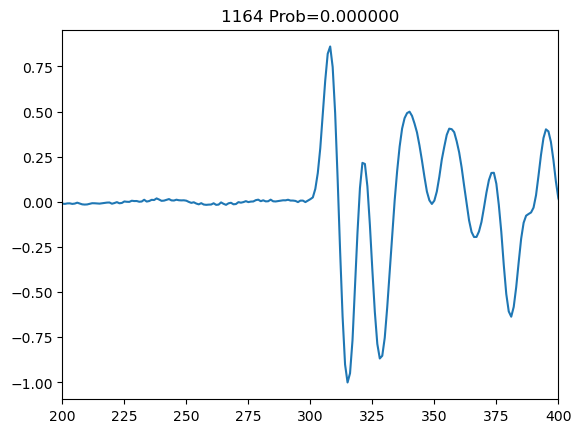

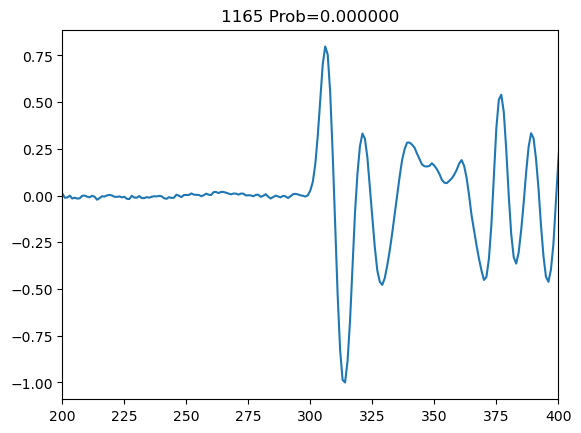

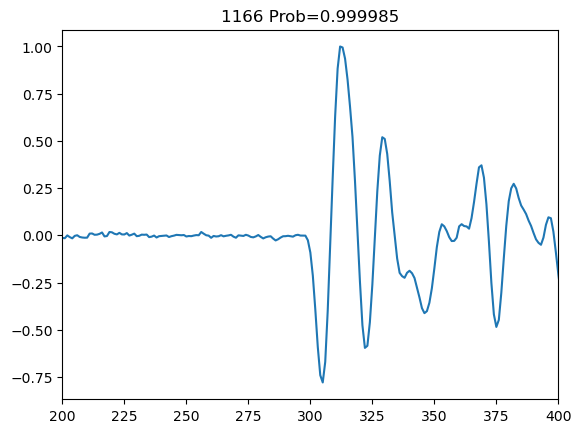

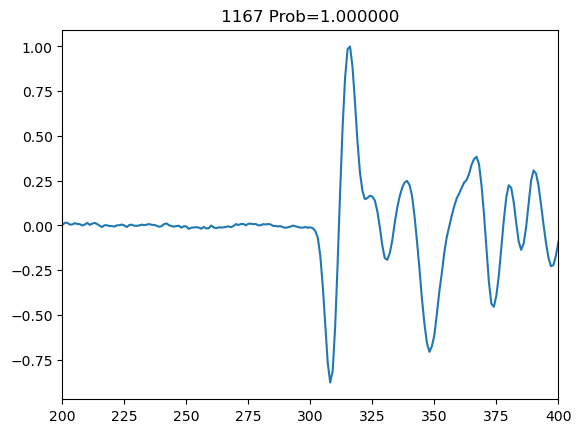

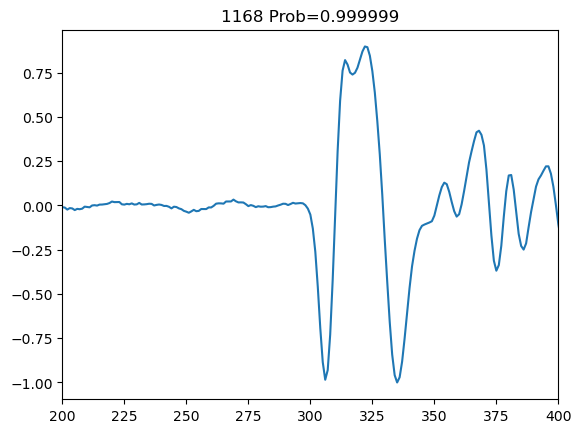

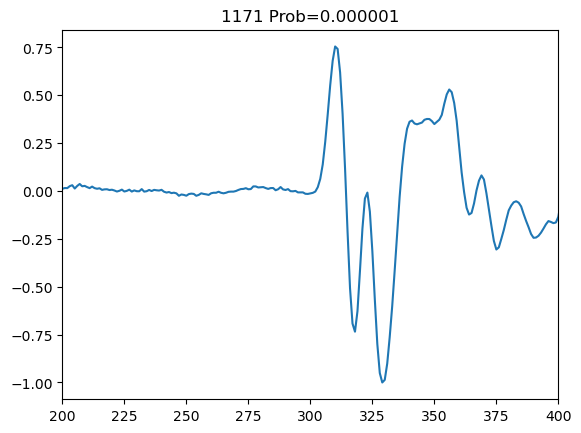

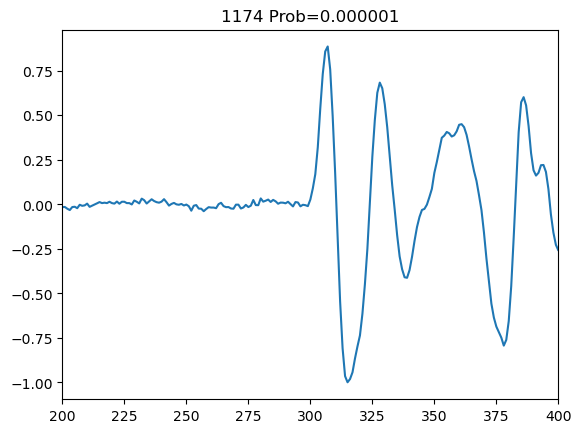

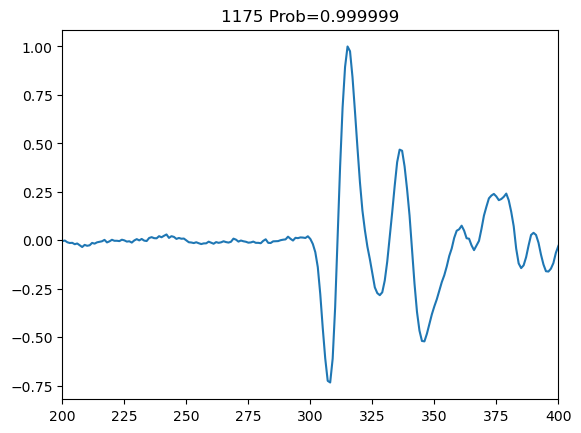

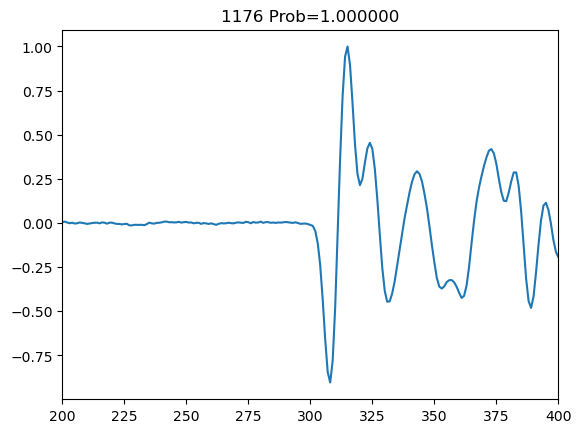

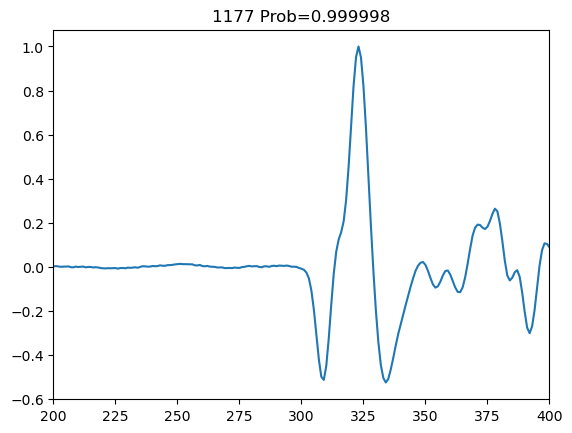

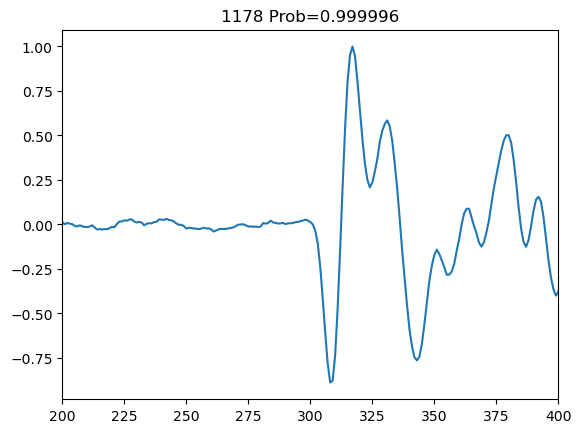

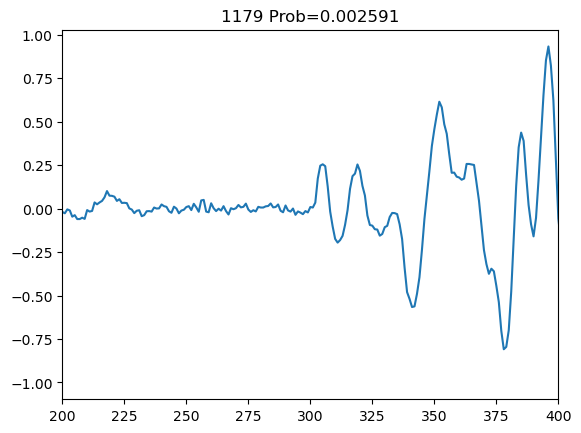

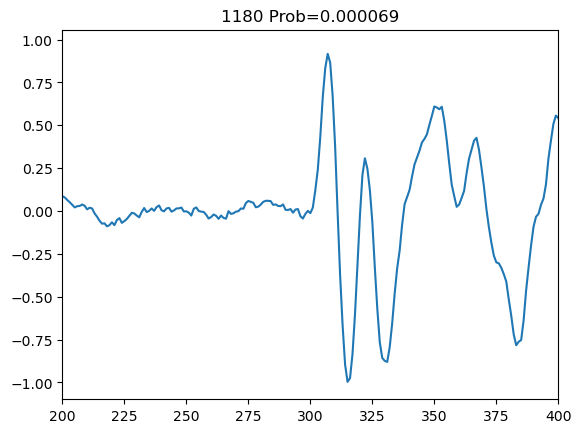

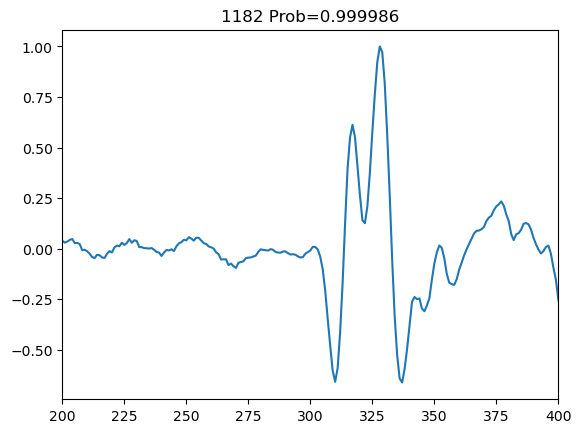

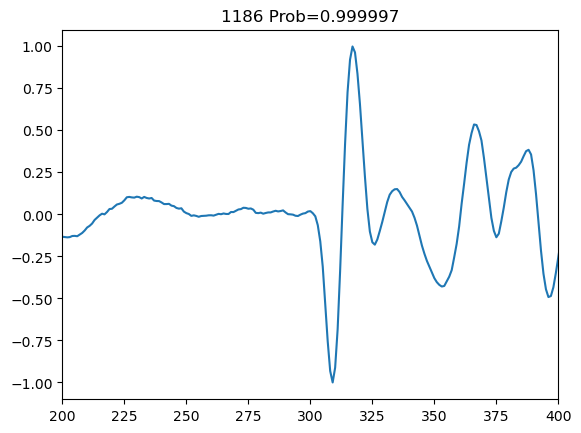

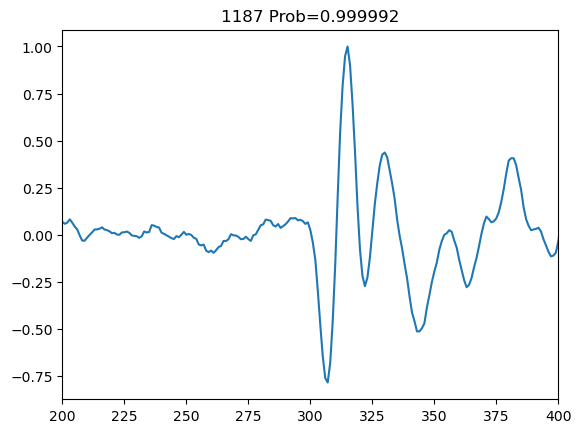

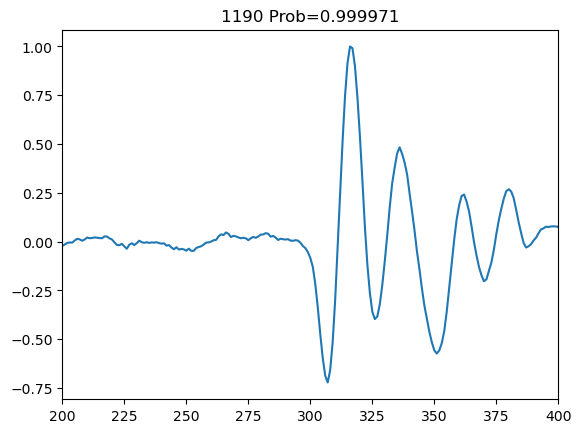

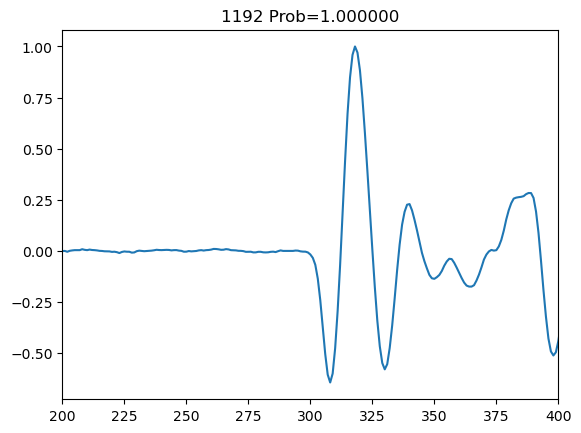

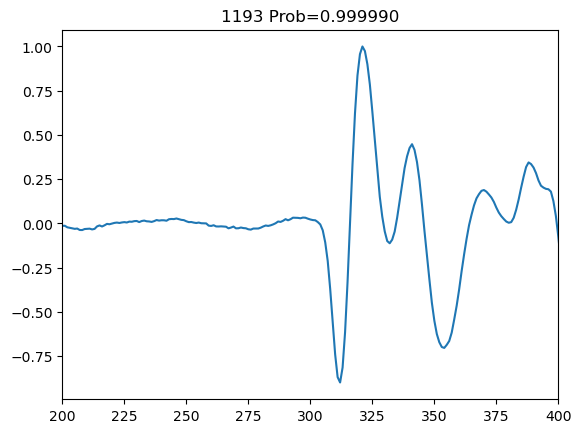

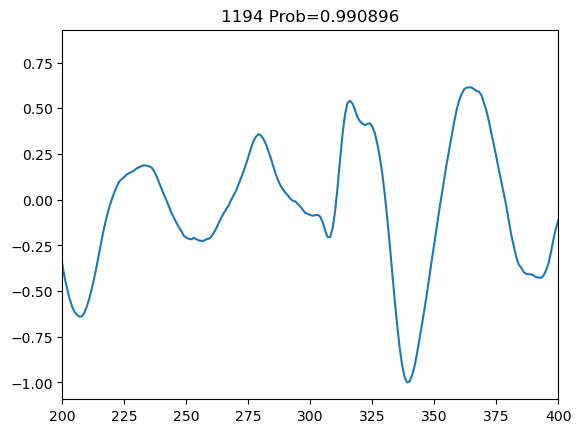

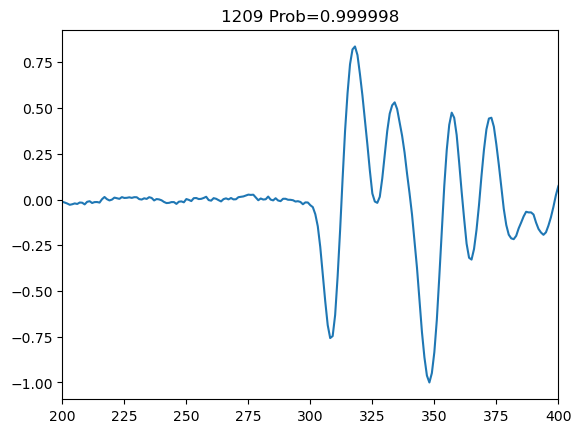

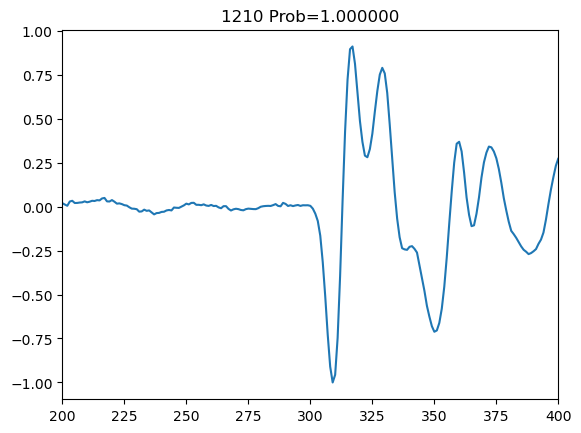

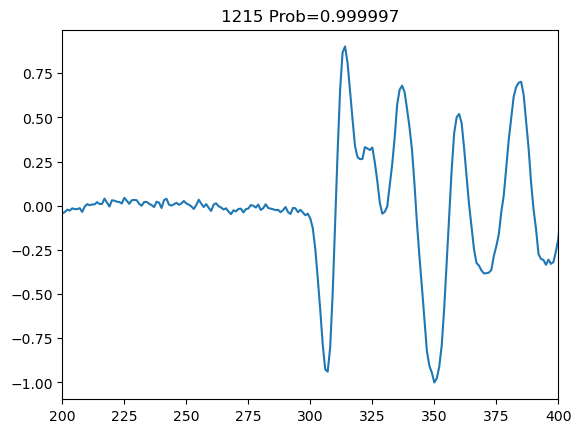

In [12]:
for idx in range(len(datall)):
    plt.figure()
    plt.plot(datall[idx])
    plt.xlim([200,400])
    plt.title('{0:s} Prob={1:f}'.format(stalist[idx],float(out[idx])))